In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

# =============================
# Step 2: Dataset Paths
# =============================
stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/stone"
no_stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/Normal"

2025-09-10 16:57:12.672357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757523432.967528     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757523433.062033     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


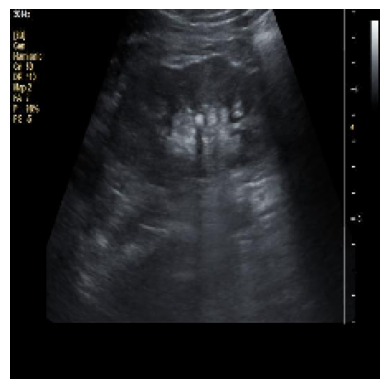

In [2]:
import matplotlib.pyplot as plt
if not os.path.exists(stone_dir):
    print(f"Directory not found: {stone_dir}")
else:
    # List files in the stone directory
    stone_files = os.listdir(stone_dir)
    if len(stone_files) > 5:
        image_path = os.path.join(stone_dir, stone_files[5])  # Take the sixth image in the directory
        
        # Load the image and convert it to a format suitable for display
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize the image (0 to 1 range)

        # Display the image
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis
        plt.show()
    else:
        print("Not enough images in the stone directory.")

In [3]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define image size for consistency
image_size = (224, 224)

# Function to load images and display them with their labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    
    # List files in the directory
    filenames = os.listdir(directory)
    if not filenames:
        print(f"Warning: No images found in {directory}")
    
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        
        # Only process jpg or png images
        if img_path.endswith(".JPG") or img_path.endswith(".png"):
            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize image values to [0, 1]
                
                # Append to images and labels lists
                images.append(img_array)
                labels.append(label)
                
                # Display the image and its label
                #plt.imshow(img_array)
                #plt.title(f"Label: {label}")  # Display the label as the title
               # plt.axis('off')  # Hide axes for a cleaner view
               # plt.show()
                
                #print(f"Image: {filename}, Label: {label}")
            except Exception as e:
                print(f"Error loading image {filename}: {e}")

    return images, labels

In [4]:
stone_images, stone_labels = load_images_from_directory(stone_dir, 1)  # Label 1 for stone
no_stone_images, no_stone_labels = load_images_from_directory(no_stone_dir, 0)  # La

In [5]:
images = np.concatenate((stone_images, no_stone_images), axis=0)
labels = np.concatenate((stone_labels, no_stone_labels), axis=0)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (7532, 224, 224, 3), Val: (942, 224, 224, 3), Test: (942, 224, 224, 3)


In [9]:
input_tensor = layers.Input(shape=(224, 224, 3))

# ResNet50 branch
resnet_input = layers.Lambda(resnet_preprocess)(input_tensor)
resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=resnet_input)
resnet_base.trainable = False
resnet_features = layers.GlobalAveragePooling2D()(resnet_base.output)

# EfficientNetB0 branch
effnet_input = layers.Lambda(effnet_preprocess)(input_tensor)
effnet_base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=effnet_input)
effnet_base.trainable = False
effnet_features = layers.GlobalAveragePooling2D()(effnet_base.output)

# Merge features
merged = layers.Concatenate()([resnet_features, effnet_features])

# Classifier head
x = layers.Dense(256, activation="relu")(merged)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation="sigmoid")(x)

hybrid_model = Model(inputs=input_tensor, outputs=output)

In [10]:
hybrid_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ lambda_3[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 28,489,764 (108.68 MB)

 Trainable params: 852,481 (3.25 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
hybrid_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Save best model
checkpoint = ModelCheckpoint("best_hybrid_model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# =============================
# Train Hybrid Model

Epoch 1/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5251 - loss: 0.7040
Epoch 1: val_loss improved from inf to 0.66381, saving model to best_hybrid_model.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 1061s 2s/step - accuracy: 0.5252 - loss: 0.7040 - val_accuracy: 0.7558 - val_loss: 0.6638
Epoch 2/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6111 - loss: 0.6624
Epoch 2: val_loss improved from 0.66381 to 0.64270, saving model to best_hybrid_model.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 1005s 2s/step - accuracy: 0.6111 - loss: 0.6624 - val_accuracy: 0.7282 - val_loss: 0.6427
Epoch 3/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6326 - loss: 0.6401
Epoch 3: val_loss improved from 0.64270 to 0.60586, saving model to best_hybrid_model.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.6327 - loss: 0.6400 - val_accuracy: 0.8153 - val_loss: 0.6059
Epoch 4/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7081 - loss: 0.6018
Epoch 4: val_loss improved from 0.60586 t

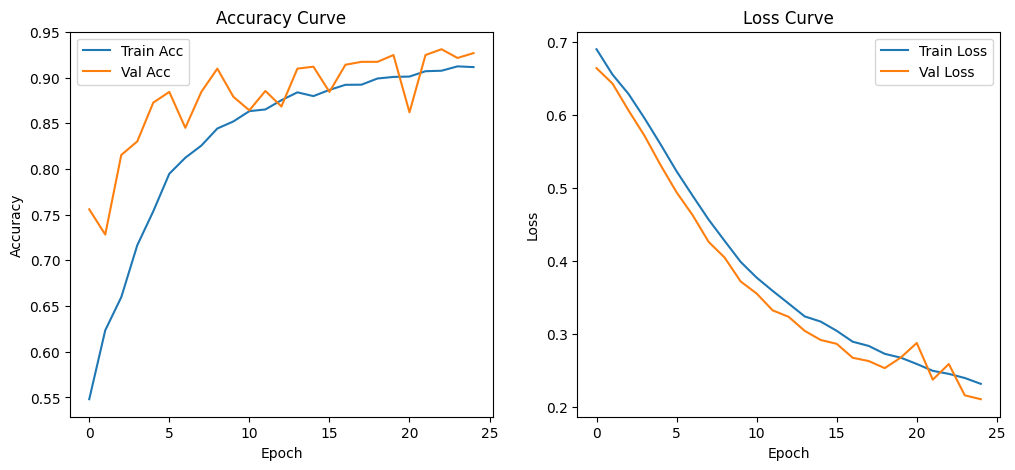

In [13]:
history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    callbacks=[checkpoint],
    verbose=1
)

# =============================
# Step 7: Evaluate on Test Set
# =============================
test_loss, test_accuracy = hybrid_model.evaluate(X_test, y_test)
print(f"🔥 Hybrid Model Test Accuracy: {test_accuracy * 100:.2f}%")

# =============================
# Step 8: Plot Accuracy & Loss
# =============================
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step


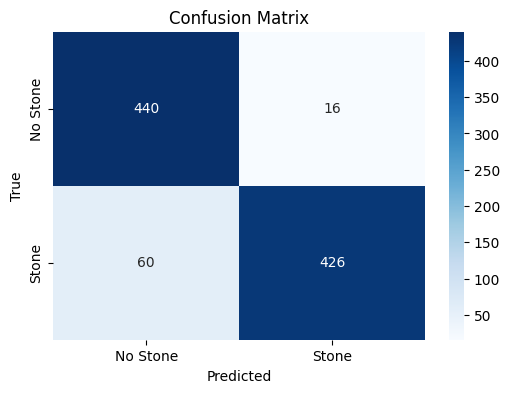

Confusion Matrix:
[[440  16]
 [ 60 426]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the test data
y_pred = hybrid_model.predict(X_test)

# Step 2: Threshold predictions to get binary outputs (0 or 1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Step 4: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print confusion matrix values for reference
print(f"Confusion Matrix:\n{cm}")